# Import

In [160]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/skolanko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/skolanko/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Preprocessing

In [166]:
# Load the data
data = pd.read_csv('realdonaldtrump.csv')
dataOriginal = data.copy()

# remove records containing URL
def remove_url(content):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',content)

# remove twiiter links to pictures: like pic.twitter.com
def remove_pic(content):
				pic = re.compile(r'pic.twitter.com/\S+')
				return pic.sub(r'',content)

# remove mentions like @username: and like @ username:
def remove_ment(content):
    mention1 = re.compile(r'@ \w+')
    mention2 = re.compile(r'@\w+')
    content = mention1.sub(r'',content)
    return mention2.sub(r'',content)

# remove punctuations
def remove_punct(content):
    table = str.maketrans('', '', string.punctuation)
    return content.translate(table)

# remove html tags
def remove_html(content):
    html=re.compile(r'<.*?>')
    return html.sub(r'',content)

# remove emojis
def remove_emoji(content):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', content)

#	decontraction
def decontraction(content):
    content = re.sub(r"won\'t", " will not", content)
    content = re.sub(r"won\'t've", " will not have", content)
    content = re.sub(r"can\'t", " can not", content)
    content = re.sub(r"don\'t", " do not", content)

    content = re.sub(r"can\'t've", " can not have", content)
    content = re.sub(r"ma\'am", " madam", content)
    content = re.sub(r"let\'s", " let us", content)
    content = re.sub(r"ain\'t", " am not", content)
    content = re.sub(r"shan\'t", " shall not", content)
    content = re.sub(r"sha\n't", " shall not", content)
    content = re.sub(r"o\'clock", " of the clock", content)
    content = re.sub(r"y\'all", " you all", content)

    content = re.sub(r"n\'t", " not", content)
    content = re.sub(r"n\'t've", " not have", content)
    content = re.sub(r"\'re", " are", content)
    content = re.sub(r"\'s", " is", content)
    content = re.sub(r"\'d", " would", content)
    content = re.sub(r"\'d've", " would have", content)
    content = re.sub(r"\'ll", " will", content)
    content = re.sub(r"\'ll've", " will have", content)
    content = re.sub(r"\'t", " not", content)
    content = re.sub(r"\'ve", " have", content)
    content = re.sub(r"\'m", " am", content)
    content = re.sub(r"\'re", " are", content)
    return content

def seperate_alphanumeric(content):
    words = content
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

# find repeated characters
def cont_rep_char(content):
    tchr = content.group(0)

    if len(tchr) > 1:
        return tchr[0:2]

#	remove repeated characters
def unique_char(rep, content):
    substitute = re.sub(r'(\w)\1+', rep, content)
    return substitute


# remove all the unwanted words	
data['content'] = data['content'].apply(lambda x : remove_pic(x))
data['content'] = data['content'].apply(lambda x : remove_url(x))
data['content'] = data['content'].apply(lambda x : remove_ment(x))
data['content'] = data['content'].apply(lambda x : remove_punct(x))
data['content'] = data['content'].apply(lambda x : remove_emoji(x))


# do the rest	of the cleaning
data['content'] = data['content'].apply(lambda x : decontraction(x))
data['content'] = data['content'].apply(lambda x : seperate_alphanumeric(x))
data['content'] = data['content'].apply(lambda x : unique_char(cont_rep_char,x))

# drop duplicates
data = data.drop_duplicates(subset=['content'])

# drop records with empty content
data = data.dropna(subset=['content'])

# remove not needed columns
data = data.drop(['link','mentions','hashtags'], axis=1)

# get stopwords to remove
stop_words=stopwords.words('english')
stemmer=SnowballStemmer('english')

def preprocess(text, stem=False):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

data['content'] = data['content'].apply(lambda x : preprocess(x))

# Data presentation

In [168]:
data.sample(5)

,id,content,date,retweets,favorites
12875,401278949277577217,Yes online Macys,2013-11-15 03:22:11,3,0
19179,545501197797691393,thats need want run president,2014-12-18 02:49:55,16,30
20107,555054614866046977,And fired celebrities via,2015-01-13 11:31:47,18,25
1013,149220720461873153,What shock The US Capitol Christmas tree pays homage failed mention Jesus,2011-12-20 14:12:46,486,218
19068,543308026472828928,When terrorists beheading executing American citizens brutal waythe report torture least concerns,2014-12-12 01:35:02,438,528


# NLP model

In [7]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(sentence):
    result = sia.polarity_scores(sentence)
    return result['compound'], result['neg'], result['neu'], result['pos']

data = data.dropna(subset=['content'])
data['content'] = data['content'].astype(str)

data['compound'], data['negative'], data['neutral'], data['positive'] = zip(*data['content'].apply(analyze_sentiment))

def categorize_sentiment(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['compound'].apply(categorize_sentiment)

data['number'] = [i+1 for i, _ in enumerate(data.iterrows())]
data = data[['number'] + list(data.columns[:-1])]

data = data.drop(columns=['id', 'retweets', 'favorites', 'date'])
data

,number,content,compound,negative,neutral,positive,sentiment
0,1,Be sure tune watch Donald Trump Late Night Dav...,0.4767,0.000,0.760,0.240,positive
1,2,Donald Trump appearing The View tomorrow morni...,0.7506,0.000,0.670,0.330,positive
2,3,Donald Trump reads Top Ten Financial Tips Late...,0.6115,0.000,0.688,0.312,positive
3,4,New Blog Post Celebrity Apprentice Finale Less...,0.0000,0.000,1.000,0.000,neutral
4,5,My persona never wallflower I rather build wal...,0.0000,0.000,1.000,0.000,neutral
...,...,...,...,...,...,...,...
43347,43348,Joe Biden TOTAL FAILURE Government He bungled ...,-0.6166,0.335,0.665,0.000,negative
43348,43349,Will interviewed seanhannity tonight 900 PM Enjoy,0.4939,0.000,0.652,0.348,positive
43349,43350,pictwittercom 3 lm 1 spbU 8 X,0.0000,0.000,1.000,0.000,neutral
43350,43351,pictwittercomvpCE 5 MadUz,0.0000,0.000,1.000,0.000,neutral


# SHAP analysis

In [8]:
# Przygotowanie danych do modelu
X = data[[ 'negative', 'neutral', 'positive', 'compound']]
y = data['sentiment']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trening modelu Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred = model.predict(X_test)

# Raport klasyfikacji
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      2141
     neutral       1.00      1.00      1.00      1588
    positive       1.00      1.00      1.00      4942

    accuracy                           1.00      8671
   macro avg       1.00      1.00      1.00      8671
weighted avg       1.00      1.00      1.00      8671



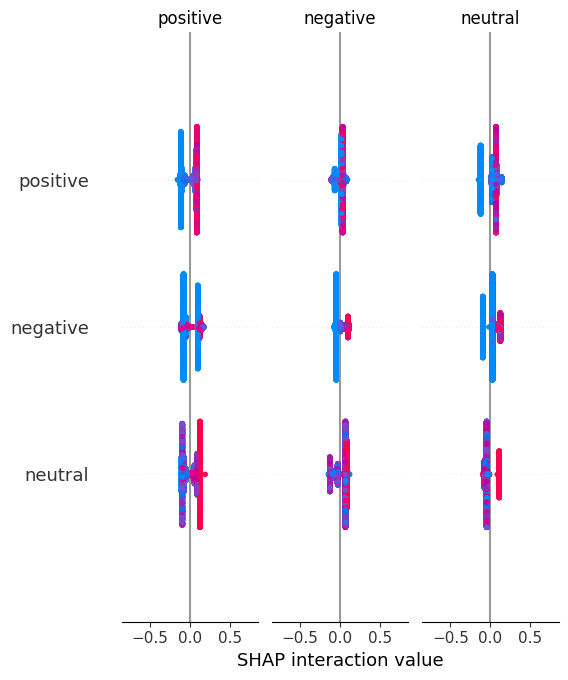

   number  number                                            content  \
0       1       1  Be sure tune watch Donald Trump Late Night Dav...   
1       2       2  Donald Trump appearing The View tomorrow morni...   
2       3       3  Donald Trump reads Top Ten Financial Tips Late...   
3       4       4  New Blog Post Celebrity Apprentice Finale Less...   
4       5       5  My persona never wallflower I rather build wal...   

   compound  negative  neutral  positive  
0    0.4767       0.0    0.760     0.240  
1    0.7506       0.0    0.670     0.330  
2    0.6115       0.0    0.688     0.312  
3    0.0000       0.0    1.000     0.000  
4    0.0000       0.0    1.000     0.000  


In [9]:
# Analiza SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Wizualizacja wartości SHAP dla predykcji
shap.summary_plot(shap_values, X_test)

# Zapisanie wyników do nowego pliku CSV
data['number'] = [i+1 for i, _ in enumerate(data.iterrows())]
df = data[['number'] + list(data.columns[:-1])]
df.to_csv('tweets_sentiment_with_model.csv', index=False)
print(df.head())